In [4]:
import os
import random
from PIL import Image
from tabulate import tabulate

In [5]:
import tqdm

# Reading the database

You can download the database here:

- [https://dna.hamilton.ie/tsterin/all_5_states_undecided_machines_with_global_header.zip](https://dna.hamilton.ie/tsterin/all_5_states_undecided_machines_with_global_header.zip)
- [ipfs://QmcgucgLRjAQAjU41w6HR7GJbcte3F14gv9oXcf8uZ8aFM](ipfs://QmcgucgLRjAQAjU41w6HR7GJbcte3F14gv9oXcf8uZ8aFM)
- [https://ipfs.prgm.dev/ipfs/QmcgucgLRjAQAjU41w6HR7GJbcte3F14gv9oXcf8uZ8aFM](https://ipfs.prgm.dev/ipfs/QmcgucgLRjAQAjU41w6HR7GJbcte3F14gv9oXcf8uZ8aFM)

Shasum (.zip): `2576b647185063db2aa3dc2f5622908e99f3cd40` 

In [6]:
DB_PATH = "all_5_states_undecided_machines_with_global_header"

## Database header
The first 30 bytes of the database are reserved for a header which currently contains **three** 4-byte int: 
1. The number of machines that are undecided because they went beyond the time limit (`47,176,870` steps)
2. The number of machines that are undecided because they went beyond the space limit (`12,289` memory cells)
3. The total number of undecided machines (sum of above)

In [7]:
def get_header(machine_db_path):
    with open(machine_db_path, "rb") as f:
        return f.read(30)

In [8]:
header = get_header(DB_PATH)
undecided_time, undecided_space, undecided_total = int.from_bytes(header[:4],byteorder='big'),int.from_bytes(header[4:8],byteorder='big'),int.from_bytes(header[8:12],byteorder='big')
print(undecided_time, undecided_space, undecided_total, header[12])

14322029 74342035 88664064 1


## Database core

The core of the database is `88,664,064` machines descriptions which are each written on 30 bytes.

In [9]:
n = os.path.getsize(DB_PATH)
print((n)/30-1)

88664064.0


In [10]:
def get_machine_i(machine_db_path, i, db_has_header=True):
    with open(machine_db_path, "rb") as f:
        c = 1 if db_has_header else 0
        f.seek(30*(i+c))
        return f.read(30)

In [11]:
def ithl(i):
    return chr(ord("A")+i)

def g(move):
    if move == 0:
        return "R"
    return "L"

def pptm(machine, return_repr=False):
    headers = ["s","0","1"]
    table = []
    
    for i in range(5):
        row = [ithl(i)]
        for j in range(2):
            write = machine[6*i+3*j] 
            move = machine[6*i+3*j+1] 
            goto = machine[6*i+3*j+2]-1
            
            if goto == -1:
                row.append("???")
                continue
                
            row.append(f"{write}{g(move)}{ithl(goto)}")
        table.append(row)
    
    if not return_repr:
        print(tabulate(table,headers=headers))
    else:
        return tabulate(table,headers=headers)

In [12]:
pptm(get_machine_i(DB_PATH,0,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  ???
B    0RC  ???
C    0RD  ???
D    0RE  ???
E    0LD  ???


In [13]:
pptm(get_machine_i(DB_PATH,10,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  ???
B    0RC  ???
C    0RD  ???
D    0RE  0LD
E    1LC  ???


In [11]:
pptm(get_machine_i(DB_PATH,4888230,db_has_header=True))

s    0    1
---  ---  ---
A    1RB  0RD
B    0RC  0LE
C    1RD  1RA
D    1LA  1LC
E    ???  1LD


# Simulating and visualising machines

In [14]:
def step(machine, curr_state, curr_pos, tape):
    if not curr_pos in tape:
        tape[curr_pos] = 0
    
    write = machine[curr_state*6 + 3*tape[curr_pos]] 
    move = machine[curr_state*6 + 3*tape[curr_pos] + 1] 
    goto = machine[curr_state*6 + 3*tape[curr_pos] + 2] - 1

    if goto == -1:
        return None, None
    
    tape[curr_pos] = write
    next_pos = curr_pos  + (-1 if move else 1)
    return goto, next_pos

In [15]:
def simulate(machine, time_limit = 1000, mini =-10, maxi=-10):
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    while curr_state != None and curr_time < time_limit:
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        if curr_state is not None:
            pprinttape(tape, curr_state, curr_pos, mini=mini, maxi=maxi)
        else:
            print("HALT")
        curr_time += 1
        

In [16]:
def tm_trace_to_image(machine, width=900, height=1000, origin=0.5, show_head_direction=False):
    img = Image.new('RGB', (width, height), color = 'black')
    pixels = img.load()
    
    
    tape = {}
    curr_time = 0
    curr_state = 0
    curr_pos = 0
    tape = {}
    
    
    for row in range(1,height):
        last_pos = curr_pos
        curr_state, curr_pos = step(machine, curr_state, curr_pos, tape)
        
        if curr_state is None: #halt
            return img
        
        for col in range(width):
            pos = col-width*(origin)
            
            if pos in tape:
                pixels[col,row] = (255,255,255) if tape[pos] == 1 else (0,0,0)
                #pixels[col,row-1] = colors[curr_state-1]
                
            if pos == curr_pos and show_head_direction:
                pixels[col,row] = (255,0,0) if curr_pos > last_pos else (0,255,0) 
                
                
    #img = zoom_at(img,*zoom)
    return img

In [17]:
def zoom_at(img, x, y, zoom):
    w, h = img.size
    zoom2 = zoom * 2
    img = img.crop((x - w / zoom2, y - h / zoom2, 
                    x + w / zoom2, y + h / zoom2))
    return img.resize((w, h), Image.LANCZOS)

## BB(5) champion

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [16]:
def repr_to_bytes(rep):
    to_rep = bytearray()
    for a in rep:
        to_rep.append(a)
    return to_rep

R, L = 0, 1
bb5_champion_repr = [1, R, 2, 1, L, 3,
		1, R, 3, 1, R, 2,
		1, R, 4, 0, L, 5,
		1, L, 1, 1, L, 4,
		1, R, 6, 0, L, 1]
bb5_champion = repr_to_bytes(bb5_champion_repr)
pptm(bb5_champion)

s    0    1
---  ---  ---
A    1RB  1LC
B    1RC  1RB
C    1RD  0LE
D    1LA  1LD
E    1RF  0LA


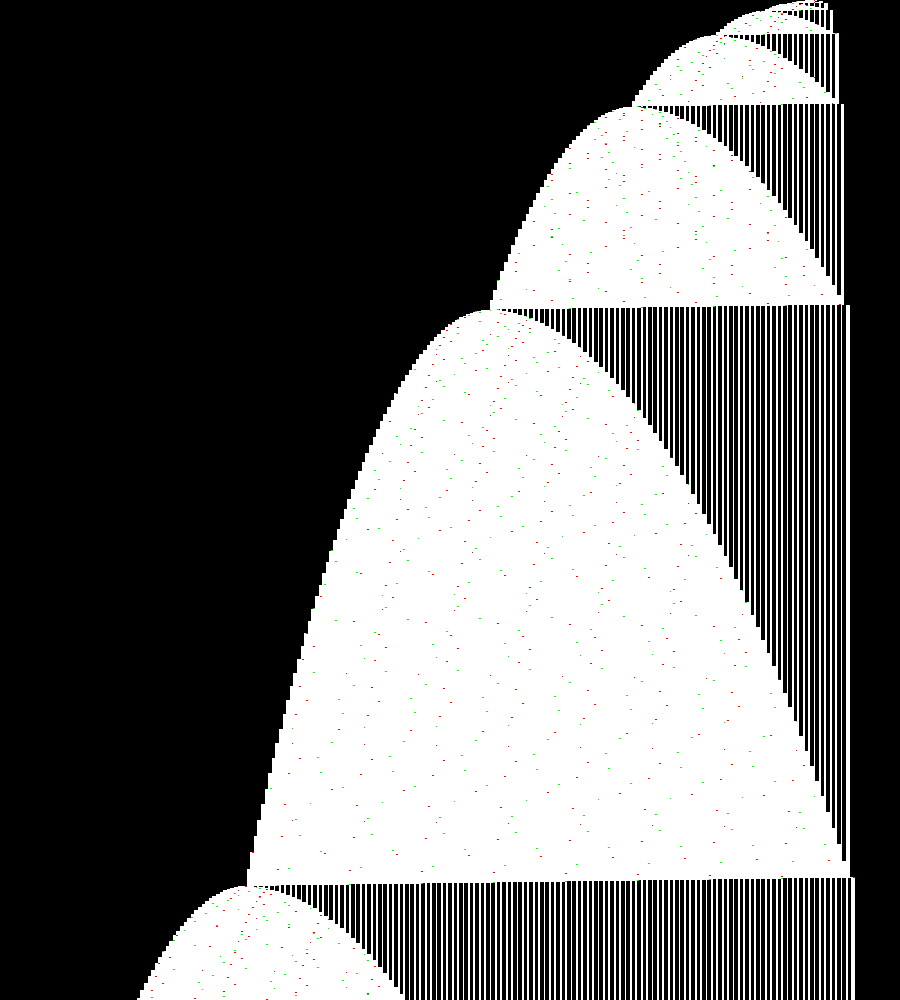

In [17]:
img = tm_trace_to_image(bb5_champion, origin=0.9, width=500, height=40000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Other Halting machines

These were find while running [https://github.com/bbchallenge/bbchallenge-seed](https://github.com/bbchallenge/bbchallenge-seed).

### 40899 steps

In [18]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 0, L, C,
		0, R, C, 0, 0, 0,
		1, R, D, 0, R, E,
		1, L, E, 0, R, A,
		0, L, A, 0, L, E]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 40899 steps.")

s    0    1
---  ---  ---
A    1RB  0LC
B    0RC  ???
C    1RD  0RE
D    1LE  0RA
E    0LA  0LE
Halts after 40899 steps.


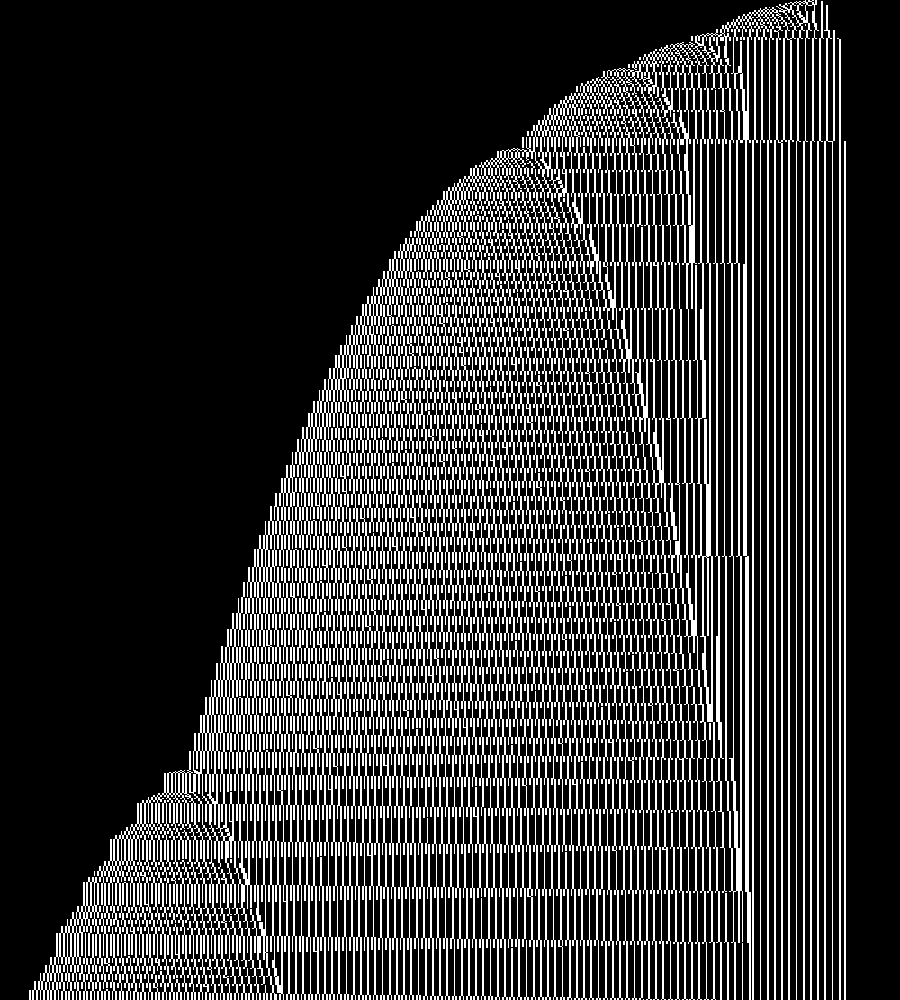

In [19]:
img = tm_trace_to_image(m, origin=0.9, width=500, height=40899).resize((900,1000), Image.NEAREST)
img

### 20739 Steps

In [20]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 0, L, A,
		0, R, C, 1, R, D,
		1, L, C, 1, L, A,
		1, R, A, 1, R, E,
		0, 0, 0, 0, R, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 20739 steps.")

s    0    1
---  ---  ---
A    1RB  0LA
B    0RC  1RD
C    1LC  1LA
D    1RA  1RE
E    ???  0RB
Halts after 20739 steps.


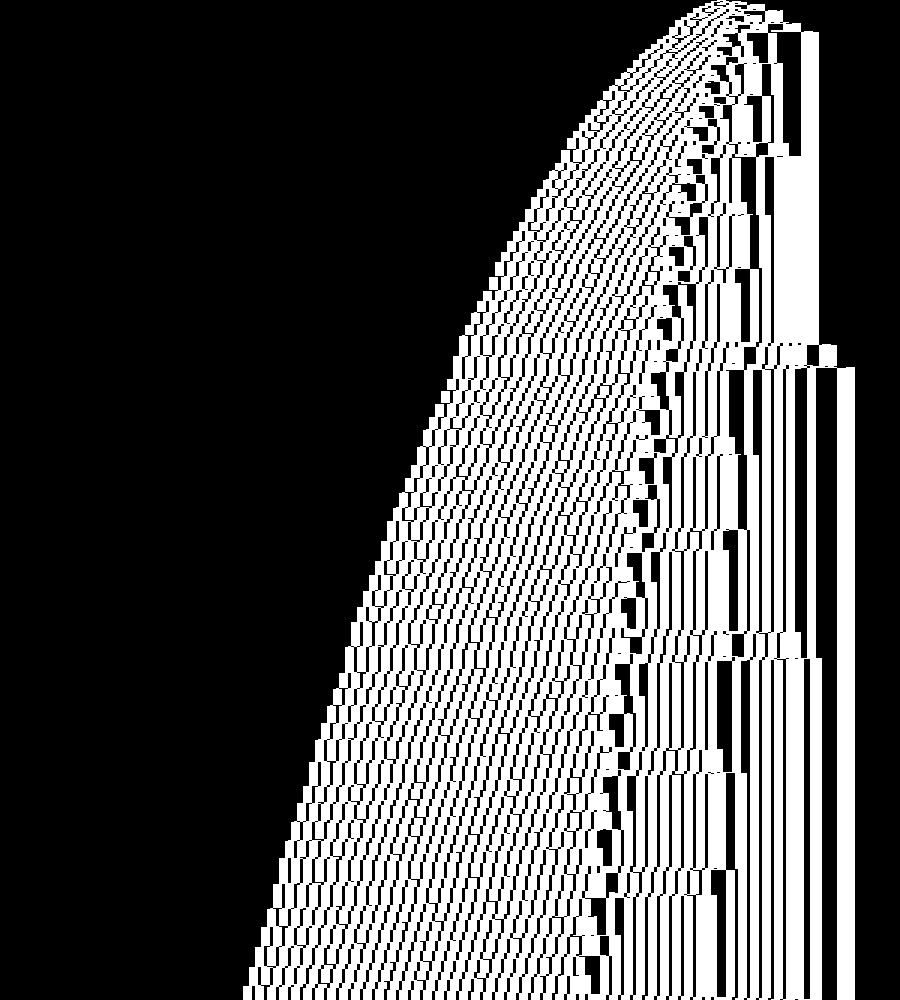

In [21]:
img = tm_trace_to_image(m, origin=0.8, width=300, height=20739).resize((900,1000), Image.NEAREST)
img

### 5309 Steps

In [22]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, D,
		0, R, C, 1, L, E,
		1, L, B, 1, R, D,
		1, R, C, 0, L, A,
		0, 0, 0, 1, L, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 5309 steps.")

s    0    1
---  ---  ---
A    1RB  1LD
B    0RC  1LE
C    1LB  1RD
D    1RC  0LA
E    ???  1LB
Halts after 5309 steps.


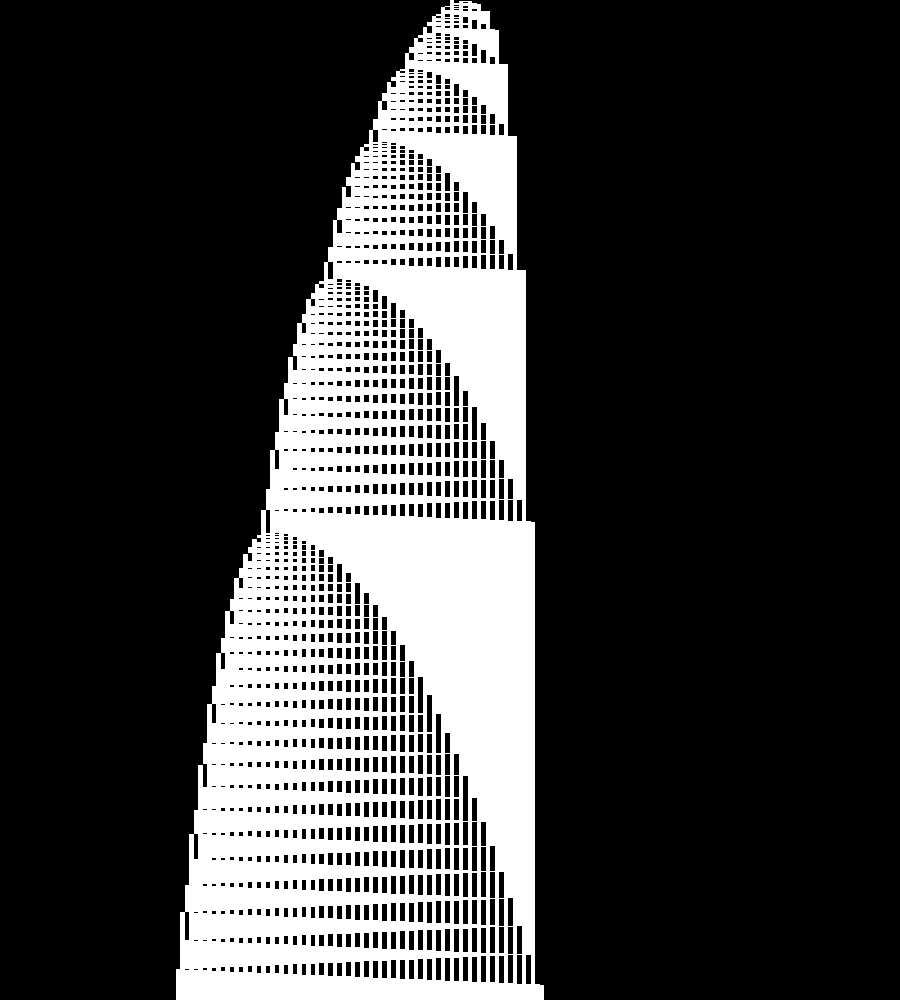

In [23]:
img = tm_trace_to_image(m, origin=0.5, width=200, height=5309).resize((900,1000), Image.NEAREST)
img

### 6987 steps

In [24]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, R, D,
		0, R, C, 1, R, C,
		1, L, A, 0, L, A,
		1, L, C, A, L, E,
		0, 0, 0, 0, L, D]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 6987 steps.")

s    0    1
---  ---  ---
A    1RB  1RD
B    0RC  1RC
C    1LA  0LA
D    1LC  1LE
E    ???  0LD
Halts after 6987 steps.


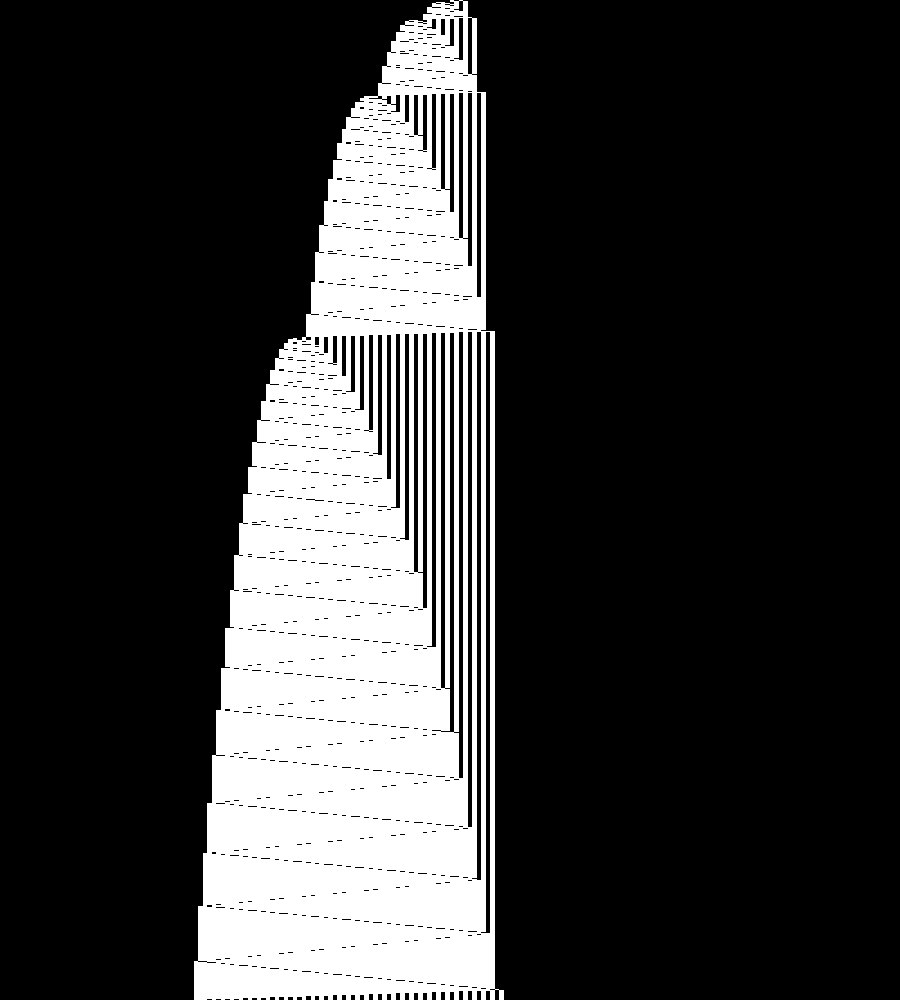

In [25]:
img = tm_trace_to_image(m, origin=0.5, width=200, height=6987).resize((900,1000), Image.NEAREST)
img

### 22335 steps

In [26]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, D,
		0, L, B, 1, R, C,
		1, L, D, 0, L, E,
		1, R, E, 1, L, C,
		0, 0, 0, 0, R, A]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 22335 steps.")

s    0    1
---  ---  ---
A    1RB  1LD
B    0LB  1RC
C    1LD  0LE
D    1RE  1LC
E    ???  0RA
Halts after 22335 steps.


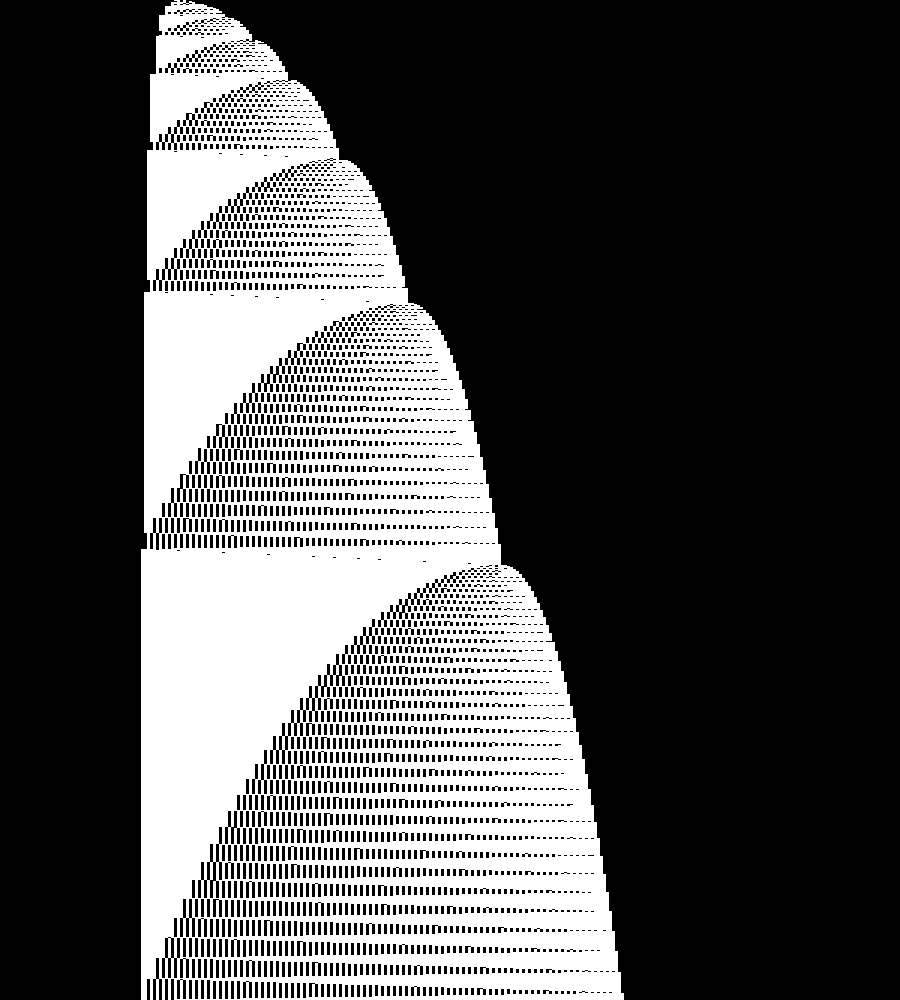

In [27]:
img = tm_trace_to_image(m, origin=0.2, width=300, height=22335).resize((900,1000), Image.NEAREST)
img

### 2133492 steps

In [28]:
R, L = 0, 1
A,B,C,D,E = 1,2,3,4,5
m_rep = [1, R, B, 1, L, C,
		0, L, A, 0, L, D,
		1, L, A, 0, 0, 0,
		1, L, B, 1, R, E,
		0, R, D, 0, R, B]
m = repr_to_bytes(m_rep)
pptm(m_rep)
print("Halts after 2133492 steps.")

s    0    1
---  ---  ---
A    1RB  1LC
B    0LA  0LD
C    1LA  ???
D    1LB  1RE
E    0RD  0RB
Halts after 2133492 steps.


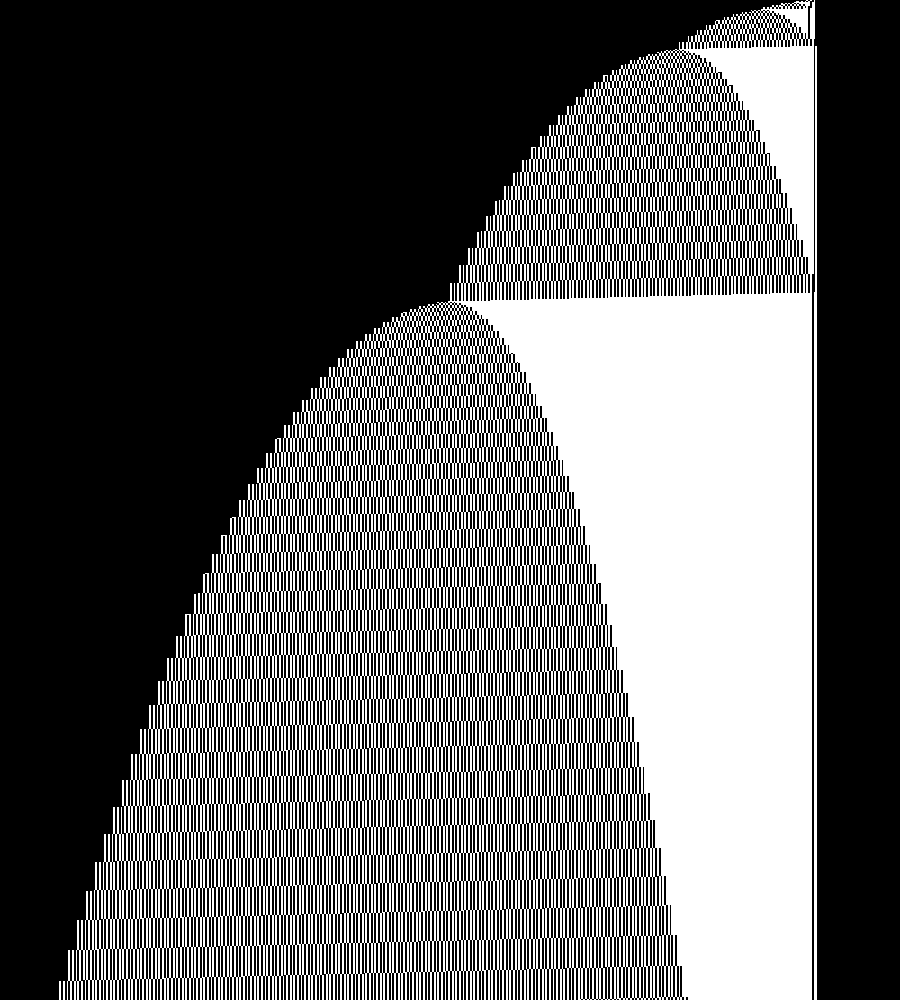

In [29]:
img = tm_trace_to_image(m, origin=0.9, width=500, height=22335).resize((900,1000), Image.NEAREST)
img

## "Chaotic" machine

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [30]:
R, L = 0, 1
chaotic_machine_rep = [1, L, 2, 1, R, 2,
		1, R, 3, 0, L, 5,
		0, R, 4, 0, L, 1,
		1, L, 1, 0, R, 4,
		1, L, 0, 0, L, 3]
chaotic_machine = repr_to_bytes(chaotic_machine_rep)
pptm(chaotic_machine)

s    0    1
---  ---  ---
A    1LB  1RB
B    1RC  0LE
C    0RD  0LA
D    1LA  0RD
E    ???  0LC


In [31]:
R, L = 1, 0
sym_chaotic_machine_rep = [1, L, 2, 1, R, 2,
		1, R, 3, 0, L, 5,
		0, R, 4, 0, L, 1,
		1, L, 1, 0, R, 4,
		0, 0, 0, 0, L, 3]
sym_chaotic_machine = repr_to_bytes(sym_chaotic_machine_rep)
pptm(sym_chaotic_machine) 
print("This is machine n = 76708232")

s    0    1
---  ---  ---
A    1RB  1LB
B    1LC  0RE
C    0LD  0RA
D    1RA  0LD
E    ???  0RC
This is machine n = 76708232


In [32]:
img = tm_trace_to_image(sym_chaotic_machine, origin=0.1, width=1000, height=100000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

KeyboardInterrupt: 

## "Complex counter"

Described in [http://turbotm.de/~heiner/BB/mabu90.html](http://turbotm.de/~heiner/BB/mabu90.html).

In [33]:
R, L = 0, 1
complex_counter_rep = [1, L, 2, 1, R, 1,
		0, R, 1, 0, L, 3,
		0, R, 3, 1, L, 4,
		1, L, 5, 0, R, 1,
		0, L, 2, 0, 0, 0]
complex_counter = repr_to_bytes(complex_counter_rep)
pptm(complex_counter)

s    0    1
---  ---  ---
A    1LB  1RA
B    0RA  0LC
C    0RC  1LD
D    1LE  0RA
E    0LB  ???


In [34]:
L, R = 0, 1
complex_counter_rep_sym = [1, L, 2, 1, R, 1,
		0, R, 1, 0, L, 3,
		0, R, 3, 1, L, 4,
		1, L, 5, 0, R, 1,
		0, L, 2, 0, 0, 0]
complex_counter_sym = repr_to_bytes(complex_counter_rep_sym)
pptm(complex_counter_sym)
R, L = 0, 1

s    0    1
---  ---  ---
A    1RB  1LA
B    0LA  0RC
C    0LC  1RD
D    1RE  0LA
E    0RB  ???


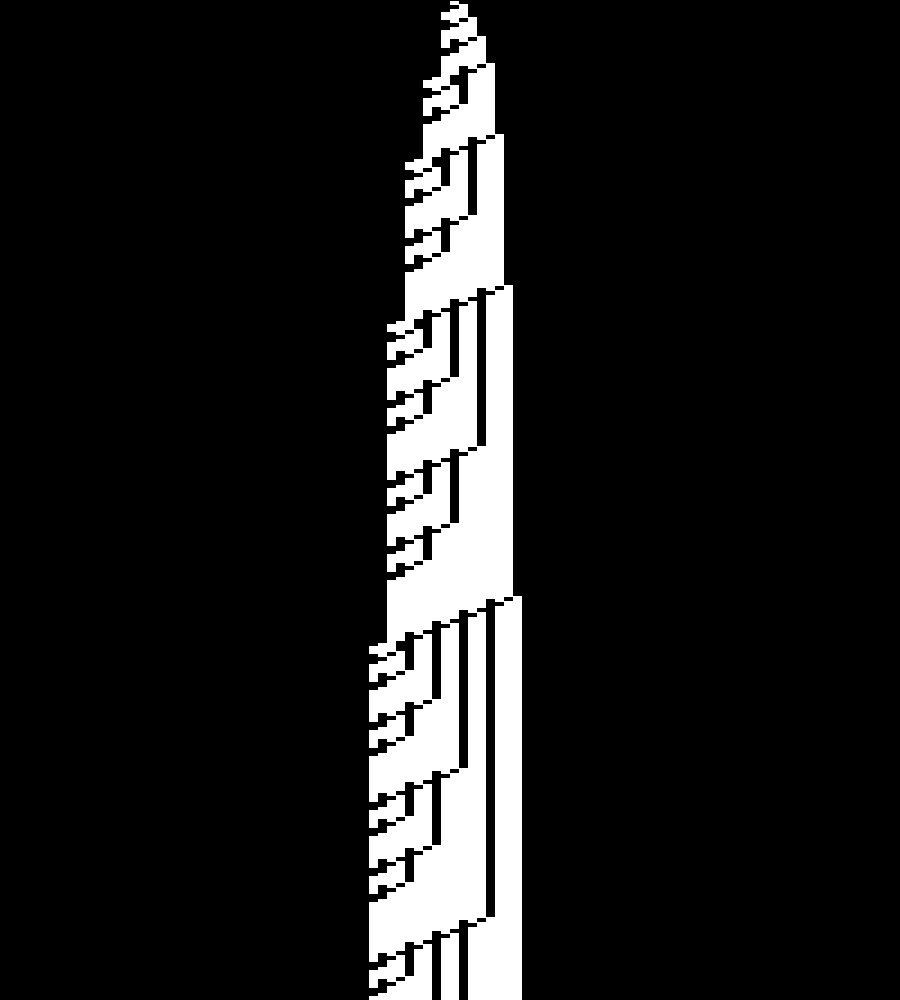

In [35]:
img = tm_trace_to_image(complex_counter, origin=0.5, width=100, height=1000, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Random machine

In [36]:
n_history = []

12534990
s    0    1
---  ---  ---
A    1RB  1LC
B    1LA  1RA
C    0LD  0RE
D    1LA  0LA
E    ???  0RD


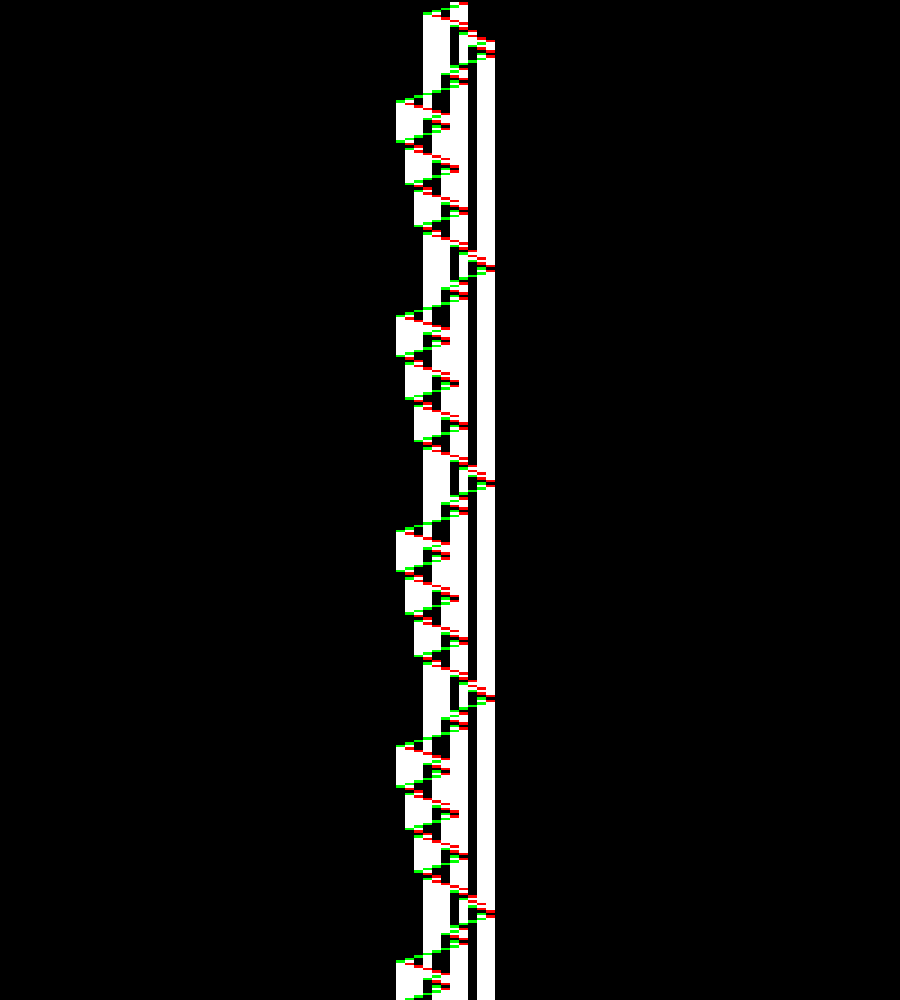

In [32]:
n = 12534990#random.randint(0,undecided_total-1)
#n_history.append(n)

print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

# Undecided Index

Available for download: https://github.com/bbchallenge/bbchallenge-undecided-index/

In [39]:
UNDECIDED_INDEX_PATH= "bb5_undecided_index"#_with_heuristics"
UNDECIDED_FILE_SIZE = os.path.getsize(UNDECIDED_INDEX_PATH)
UNDECIDED_FILE_SIZE

6154448

In [40]:
undecided_index = []
with open(UNDECIDED_INDEX_PATH, "rb") as f:
    for i in range(UNDECIDED_FILE_SIZE//4):
        chunk = f.read(4)
        undecided_index.append(int.from_bytes(chunk, byteorder="big"))

In [41]:
undecided_time_index = []
undecided_space_index = []
for i in undecided_index:
    if i < undecided_time:
        undecided_time_index.append(i)
    else:
        undecided_space_index.append(i)
print(len(undecided_time_index), len(undecided_space_index))

1234353 304259


In [42]:
def is_sub_machine(m,m1):
    """ m sub machine of m1"""
    for i in range(len(m)//3):
        if m[3*i+2] == 0:
            continue
        for j in range(3):
            if m[3*i+j] != m1[3*i+j]:
                return False
    return True

In [43]:
def count_undef_trans(m):
    undef_trans = 0 
    for i in range(len(m)//3):
        if m[3*i+2] == 0:
            undef_trans += 1
    return undef_trans

In [44]:
c = 0
det_count = {}
for undecided_id in undecided_index:
    m = get_machine_i(DB_PATH,undecided_id)
    ut = count_undef_trans(m)
    if ut > 1:
        if ut not in det_count:
            det_count[ut] = []
        det_count[ut].append(undecided_id)
        c += 1

In [45]:
print(c)

96554


In [46]:
for a in det_count:
    print(a, len(det_count[a]))

3 2444
2 94110


# Looking for 2 machines of Marxen and Buntrock

The following code checks if a given machine description is in the index. We are interesting in finding the ID of the "chaotic machine" and the "complex counter" described in Marxen and Buntrock, 1990. We find IDs `76708232` for the chaotic machine and `10936909` for the complex counter.

In [48]:
def getMachineID(m, indexToLookOutFrom, printSubMachines=False):
    for i in tqdm.tqdm(indexToLookOutFrom):
        m2 = get_machine_i(DB_PATH,i)
        if m2 == m:
            return i
        if is_sub_machine(m2,m) and printSubMachines:
            print(i)
            pptm(m2)
    print("Not found")
    return None

In [49]:
pptm(sym_chaotic_machine)

s    0    1
---  ---  ---
A    1RB  1LB
B    1LC  0RE
C    0LD  0RA
D    1RA  0LD
E    ???  0RC


In [50]:
getMachineID(sym_chaotic_machine,undecided_space_index)

 84%|████████▍ | 255959/304259 [00:03<00:00, 73457.59it/s]


76708232

In [51]:
getMachineID(complex_counter_sym,undecided_time_index)

 71%|███████   | 879193/1234353 [00:11<00:04, 76812.21it/s]


10936909

# Random Undecided Machine

In [52]:
n_history = []

In [ ]:
n = random.choice(undecided_index)
n_history.append(n)
print(n)
#pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

NameError: name 'n_history' is not defined

## List of random undecided machines for speedy lookin

7039177


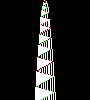

3279752


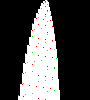

50393547


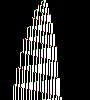

44791988


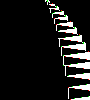

38179675


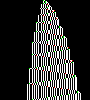

9696937


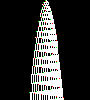

58082868


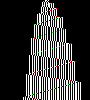

13204392


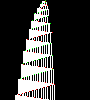

5225797


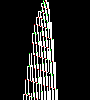

14266644


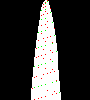

11383671


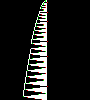

6593417


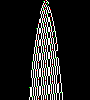

6270882


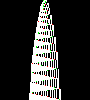

24358371


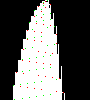

13473940


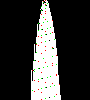

60250386


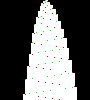

64995697


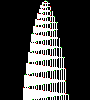

7230779


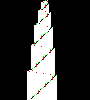

1265115


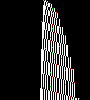

4469191


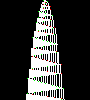

4892557


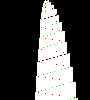

1918127


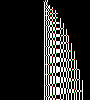

8429644


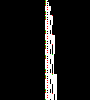

60318162


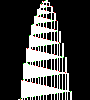

13096305


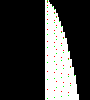

2205145


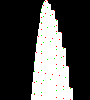

14168931


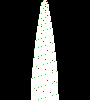

34249695


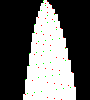

10069074


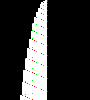

6423513


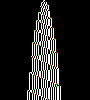

12060606


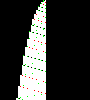

13015037


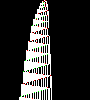

6835908


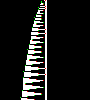

13242095


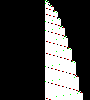

4539248


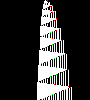

5295526


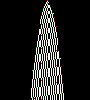

3184179


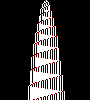

676811


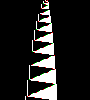

9352739


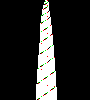

3245873


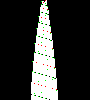

8110301


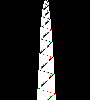

7246495


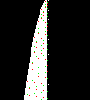

1027958


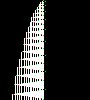

41934512


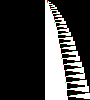

7989896


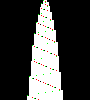

9468284


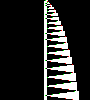

9773518


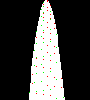

10966396


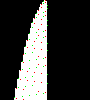

67554320


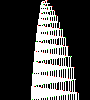

12852944


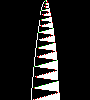

11734185


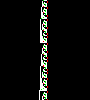

44743222


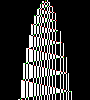

9162769


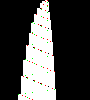

8209058


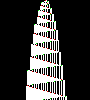

5282491


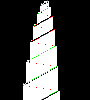

776153


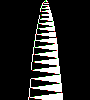

752467


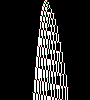

11414172


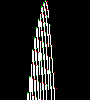

11591363


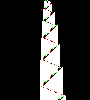

6546855


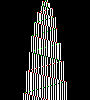

12145758


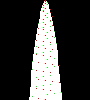

13561072


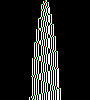

10470762


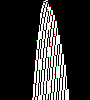

3473300


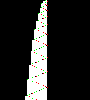

3523564


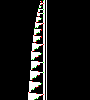

8777993


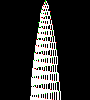

11749966


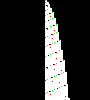

12917230


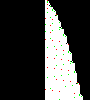

2265266


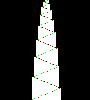

7240215


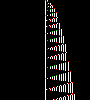

86317446


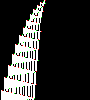

59818277


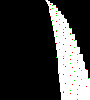

13600749


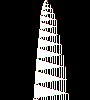

80846113


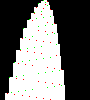

7342625


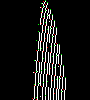

7610735


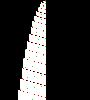

9652764


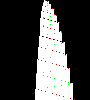

9994026


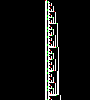

3473009


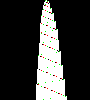

74532412


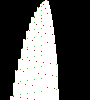

11159896


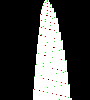

11739843


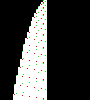

5231259


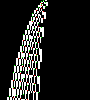

51060647


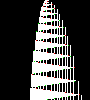

8073089


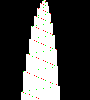

13265209


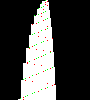

710786


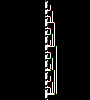

11071895


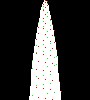

5357648


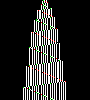

12127628


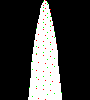

7679462


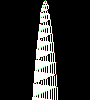

5824353


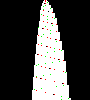

2677648


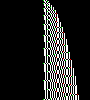

4946561


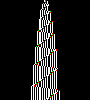

6288860


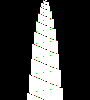

11819674


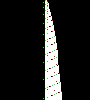

7267112


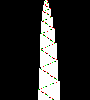

10752414


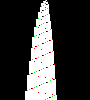

13389206


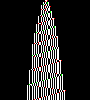

7943851


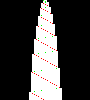

11496054


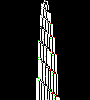

8781995


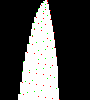

7578950


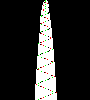

9949793


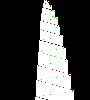

10513847


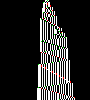

43959247


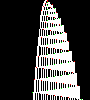

8161828


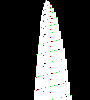

63592498


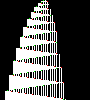

20769070


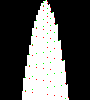

3180558


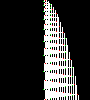

28652840


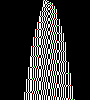

2773869


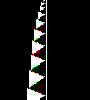

7180475


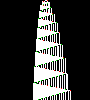

12913468


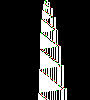

3475096


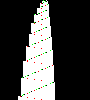

1625442


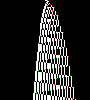

21966605


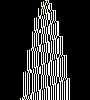

11941029


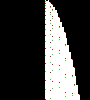

66480139


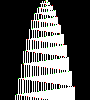

79313091


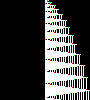

672221


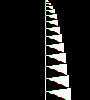

7876514


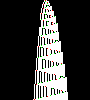

10726576


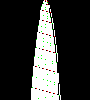

12448798


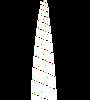

1173000


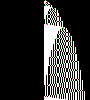

78651867


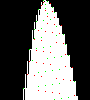

13407010


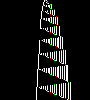

11922301


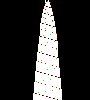

2258142


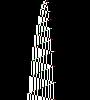

13930236


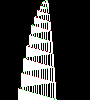

7871766


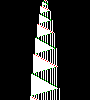

10159833


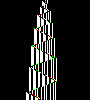

13024630


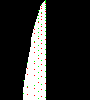

305193


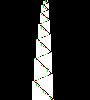

6720619


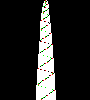

12734897


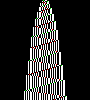

31485375


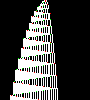

7026325


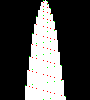

11015179


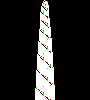

2174770


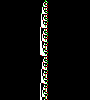

6927630


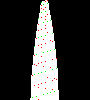

6634109


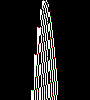

6312546


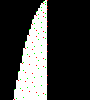

52918949


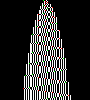

6333970


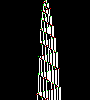

10476926


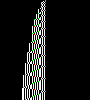

7503132


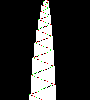

13159330


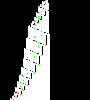

33178982


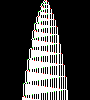

10171347


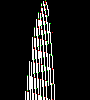

12340397


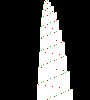

5491071


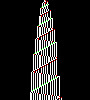

8383841


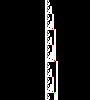

40588371


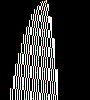

78743776


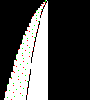

55180546


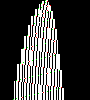

11599557


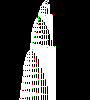

5918623


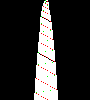

8144150


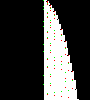

18599280


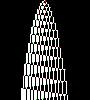

8286857


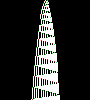

9212271


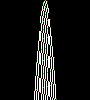

957394


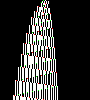

72614289


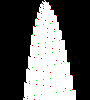

11160808


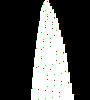

13121174


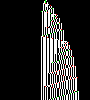

7885375


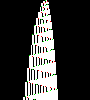

7920737


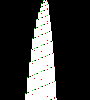

6041763


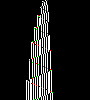

11911559


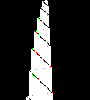

10718856


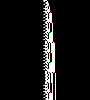

10904135


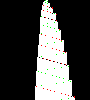

12068889


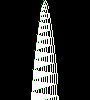

38149576


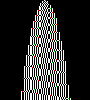

13374701


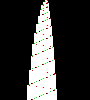

8514481


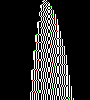

65659239


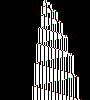

6068227


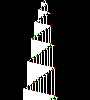

3327887


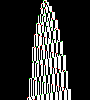

6529133


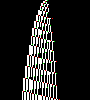

7738590


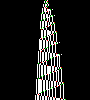

5877285


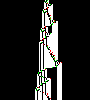

9038997


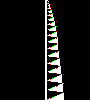

2024195


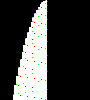

12743095


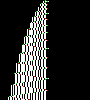

1276374


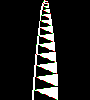

9794412


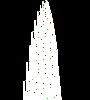

50756231


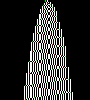

60282973


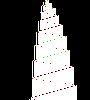

13805369


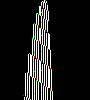

13905550


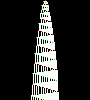

6289358


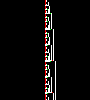

9035312


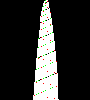

7358126


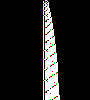

237392


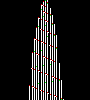

6882444


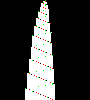

10355790


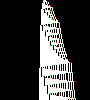

7792680


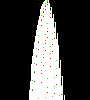

11087114


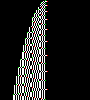

10366844


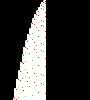

In [54]:
for _ in range(200):
    n = random.choice(undecided_index)
    print(n)
    #pptm(get_machine_i(DB_PATH,n))
    img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=800, show_head_direction=True).resize((90,100), Image.NEAREST)
    display(img)

### Temporary machine under scrutiny

7410754
s    0    1
---  ---  ---
A    1RB  0LD
B    1LC  1RC
C    1LA  0RC
D    ???  0LE
E    0RB  1LD


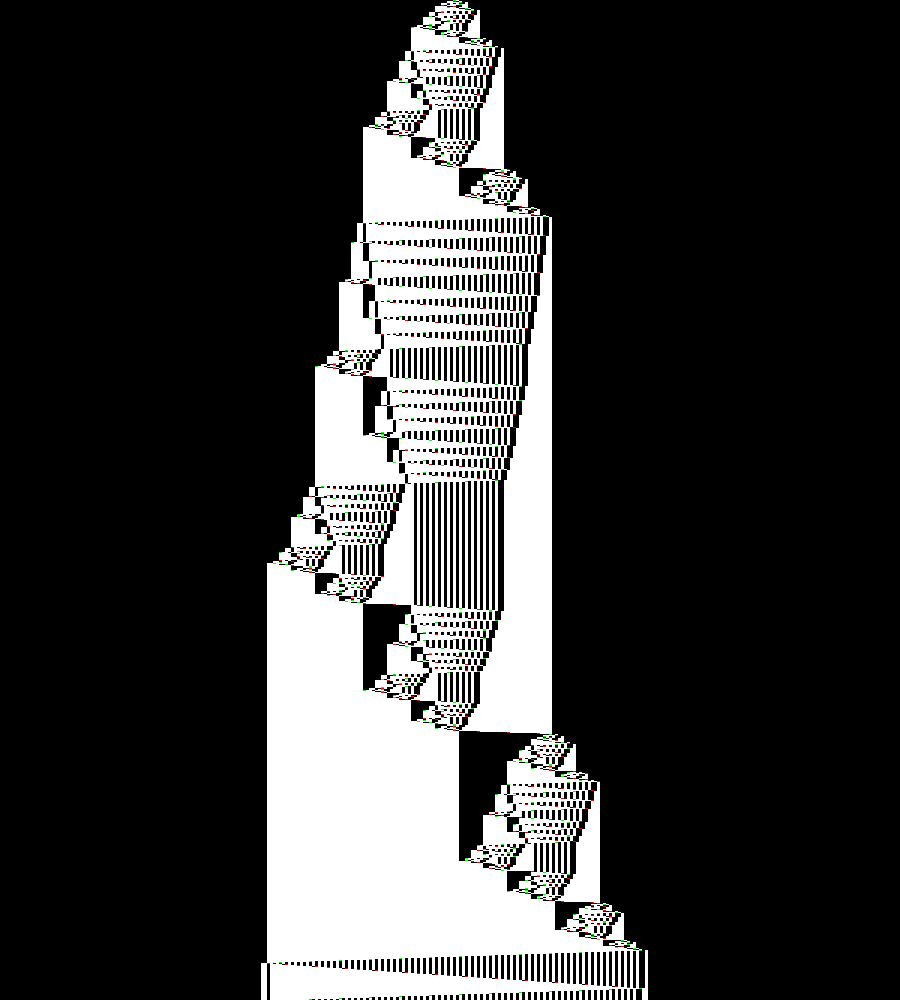

In [55]:
n = 7410754
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=300, height=10000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

# Zoology

## Cyclers

**Update 28/01/22**. 11 229 238 cyclers were decided (among machines that exceeded time limit) thanks to this decider: [https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-cyclers](https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-cyclers).

4231819
s    0    1
---  ---  ---
A    1RB  0RB
B    1LC  1RC
C    0LD  0LD
D    1RE  1LA
E    1RD  ???


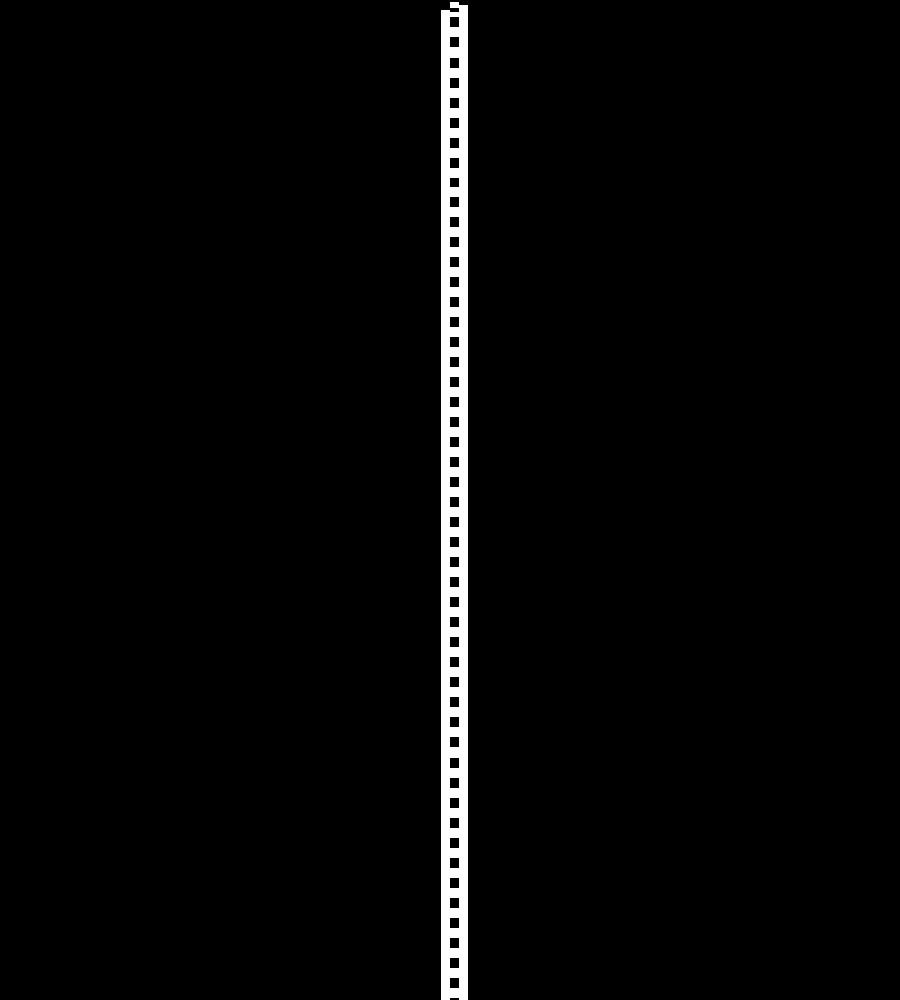

In [56]:
n_list = [11636047, 4231819, 279081]
n = random.choice(n_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=False).resize((900,1000), Image.NEAREST)
img

## Translated Cyclers

**Update 29/01/22**. 73 857 622 translated-cyclers were decided (among machines that exceeded space limit) thanks to the translated-cyclers decider:
[https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-translated-cyclers](https://github.com/bbchallenge/bbchallenge-deciders/tree/main/decider-translated-cyclers).

14427007
s    0    1
---  ---  ---
A    1RB  ???
B    0RC  ???
C    1LD  ???
D    0LD  1RE
E    1LE  0RD


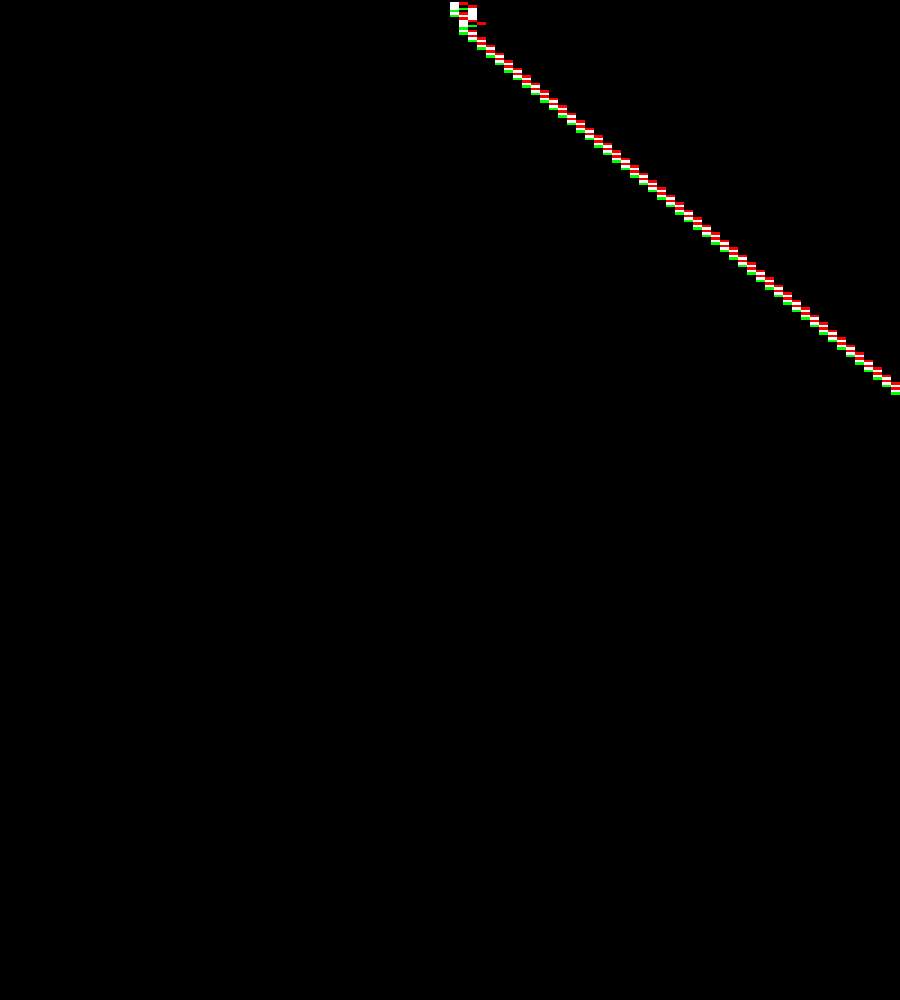

In [57]:
n_list = [32510779, 45010518, 14427007, 14643029, 15167997, 50491158, 59645887, 31141863, 28690248]
n = random.choice(n_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Complex translated cyclers

They are translated cyclers but we discovered them later in a smaller 200k sample remaining of the 88M undecided machines. They were most probably missed by the translated-cyclers decider because they need bigger parameters to be recognised. We will re-run the decider with those higher parameters.

74980673
s    0    1
---  ---  ---
A    1RB  1LB
B    0RC  1LC
C    1LD  0LA
D    0RE  1RA
E    ???  1RC


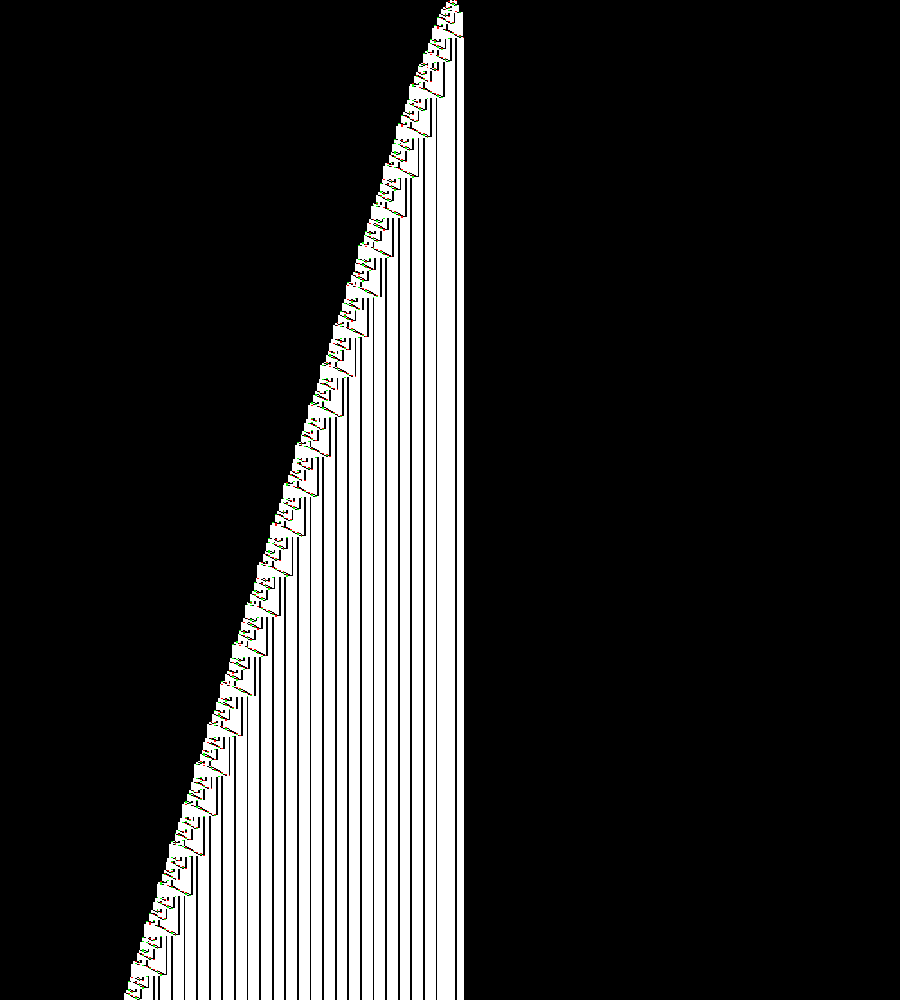

In [58]:
complex_translated_cyclers = [46965866, 74980673, 88062418, 59090563, 76989562, 46546554, 36091834, 58966114]
n = random.choice(complex_translated_cyclers)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=500, height=10000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Unilateral Pongs

7704208
s    0    1
---  ---  ---
A    1RB  0LE
B    1RC  ???
C    0LD  1RA
D    0RB  0RE
E    1LC  0LC


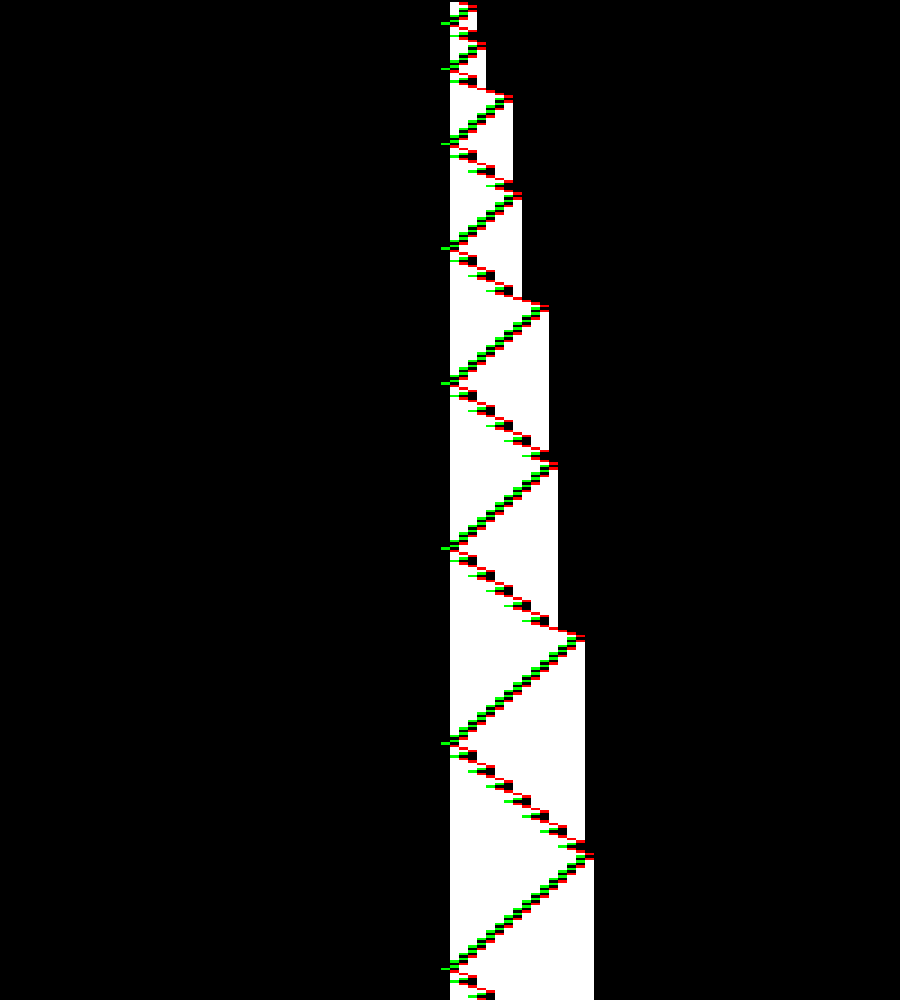

In [59]:
unilateral_pongs_list = [1897885, 524224, 9281450, 8512220, 872367, 13021228, 1288796, 376121, 
                         13781608, 13365152, 3740717, 2683159, 5357965, 12604461, 8541624, 9420847, 
                         7322529, 4830758, 9240606, 12483700, 6411252, 4685904, 1440807, 2107819, 
                         2953298, 11660591, 846128, 12315679, 7704208, 8100160, 3437121, 13410247, 
                         2957273, 11545063, 7865959, 1321388]
n = random.choice(unilateral_pongs_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Translated Unilateral Pongs

6092912
s    0    1
---  ---  ---
A    1RB  0LB
B    1RC  0RD
C    0RD  1LC
D    1LE  0RA
E    0LA  ???


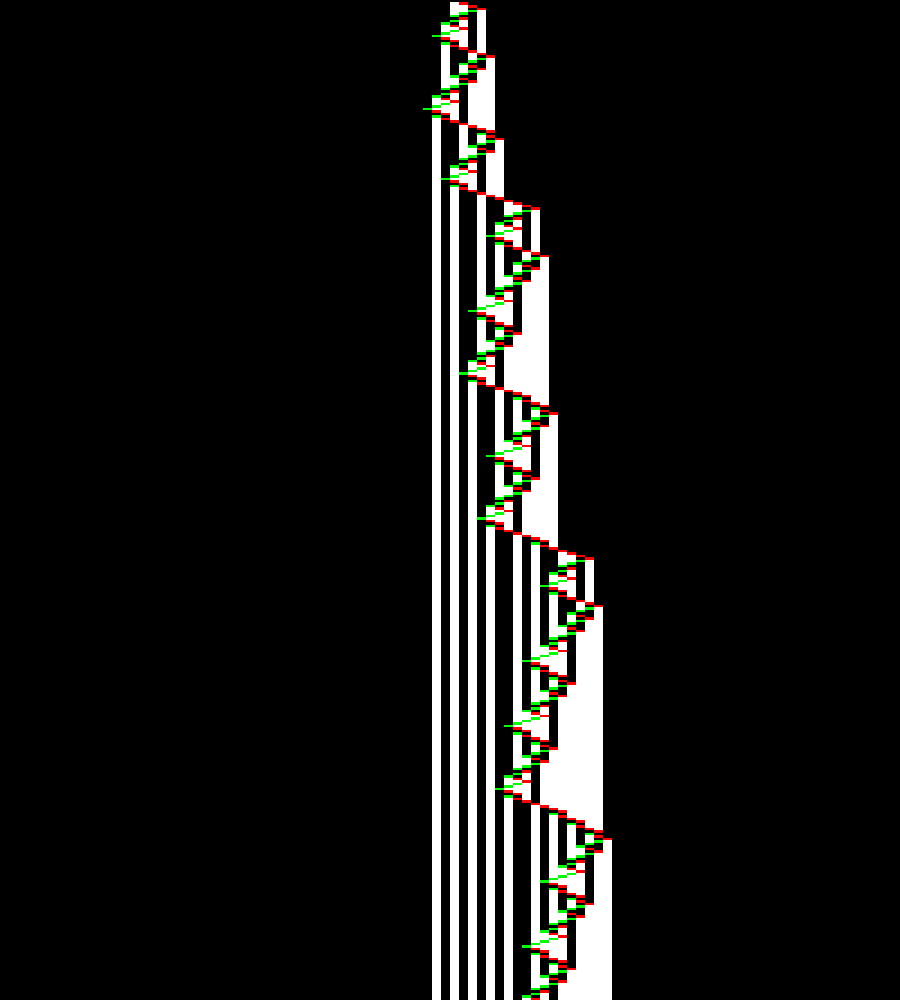

In [60]:
translated_unilateral_pongs_list = [42255, 83854998, 6164147, 11275965, 20076854, 11263544, 6092912, 
                                    12027627, 7728246]
n = random.choice(translated_unilateral_pongs_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Bilateral Pongs

3467845
s    0    1
---  ---  ---
A    1RB  ???
B    1LC  1RE
C    1RE  0RD
D    1LB  1LB
E    0LC  1RB


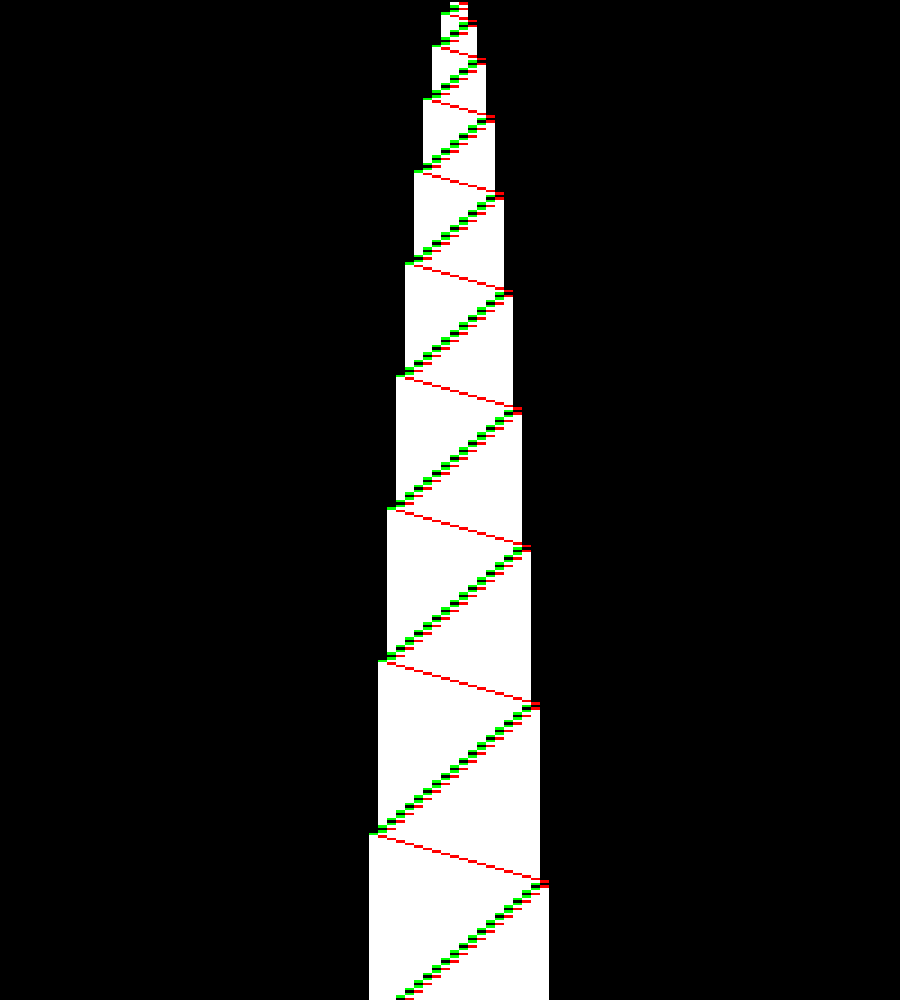

In [61]:
bilateral_pongs_list = [12785688, 8929416, 76727755, 8179149, 8680193, 10955739, 58057, 10784014, 
                        10750857, 82820597, 9627910, 10788462, 2488210, 14155579, 2712075, 5531970, 
                        9099315, 11323181, 1550671, 8631993, 6686258, 3301037, 9357684, 7260722, 
                        12604461, 7083973, 11685160, 14076871, 10879705, 15439564, 167872, 12112369,
                        2815026, 7762990, 9556263, 9660079, 1828616, 10278087, 2163518, 5747101, 
                        10436913, 400772, 626088, 6251627, 965550, 8759155, 11223826, 10753312, 
                        3467845, 4897489, 9003220, 8570030, 11270715, 27293997, 5699889, 9829009, 
                        59839853, 6170236, 11982212, 7164345, 8189825, 12875376, 12764993, 13199370, 
                        2272659, 4789124, 9105362, 12846440, 40562752, 3336092, 9124284, 6283269, 
                        71791981, 8813622, 11319132, 3405717, 7890444, 86152240, 9562099, 11185189, 
                        153481, 10667540, 69838082, 4139167, 11790195, 6283761, 6040629, 2963361, 
                        11341640, 3133305, 6223673, 9129536, 10884143, 35695274, 5253373, 12304289, 
                        3814868, 10866122, 298605, 6345422, 8192282, 4793378]
n = random.choice(bilateral_pongs_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Exponential Counters

6486385
s    0    1
---  ---  ---
A    1RB  0LC
B    0LC  1RA
C    0RA  1LD
D    1LE  1LC
E    1RC  ???


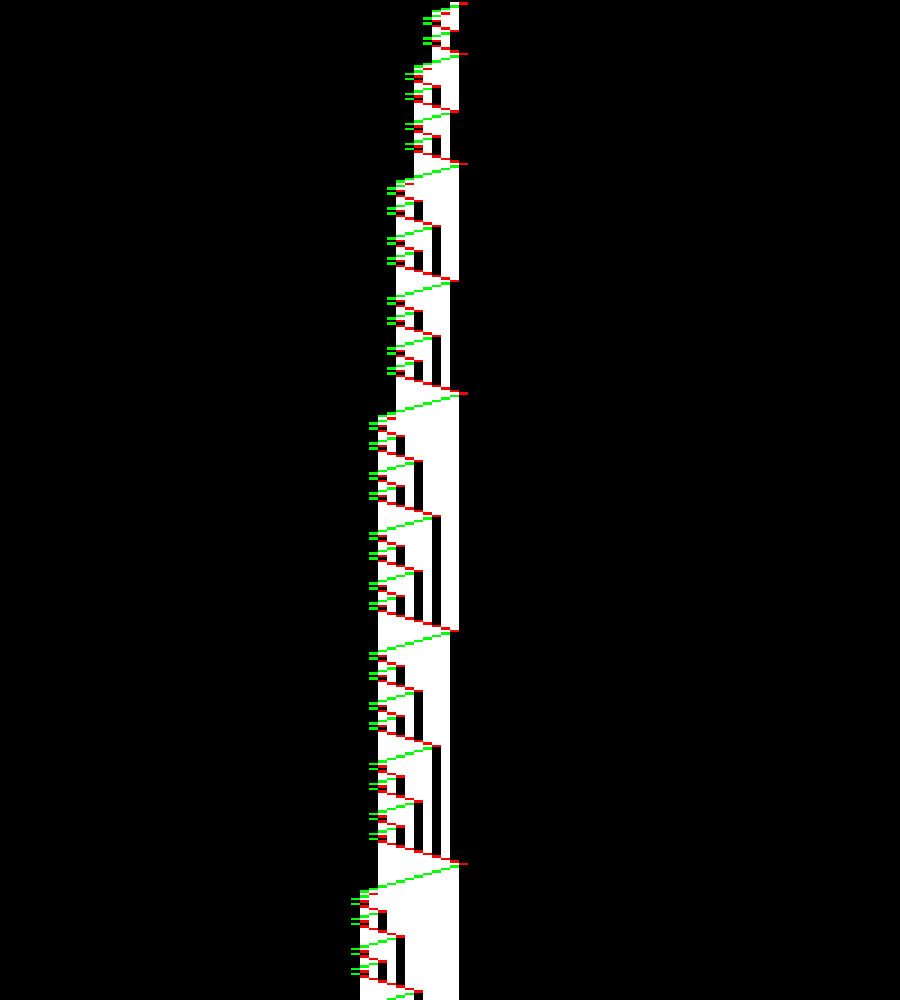

In [62]:
smart_counters = [14244805, 8413822, 2351048, 903500, 2940201, 437775, 10126234, 12012425, 
                  14263231, 6245415, 6776164, 3266856, 2940930, 6486385]
n = random.choice(smart_counters)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Potential Halters

28086713
s    0    1
---  ---  ---
A    1RB  ???
B    1LC  0RA
C    1RD  0LB
D    0LE  1RC
E    ???  0LC


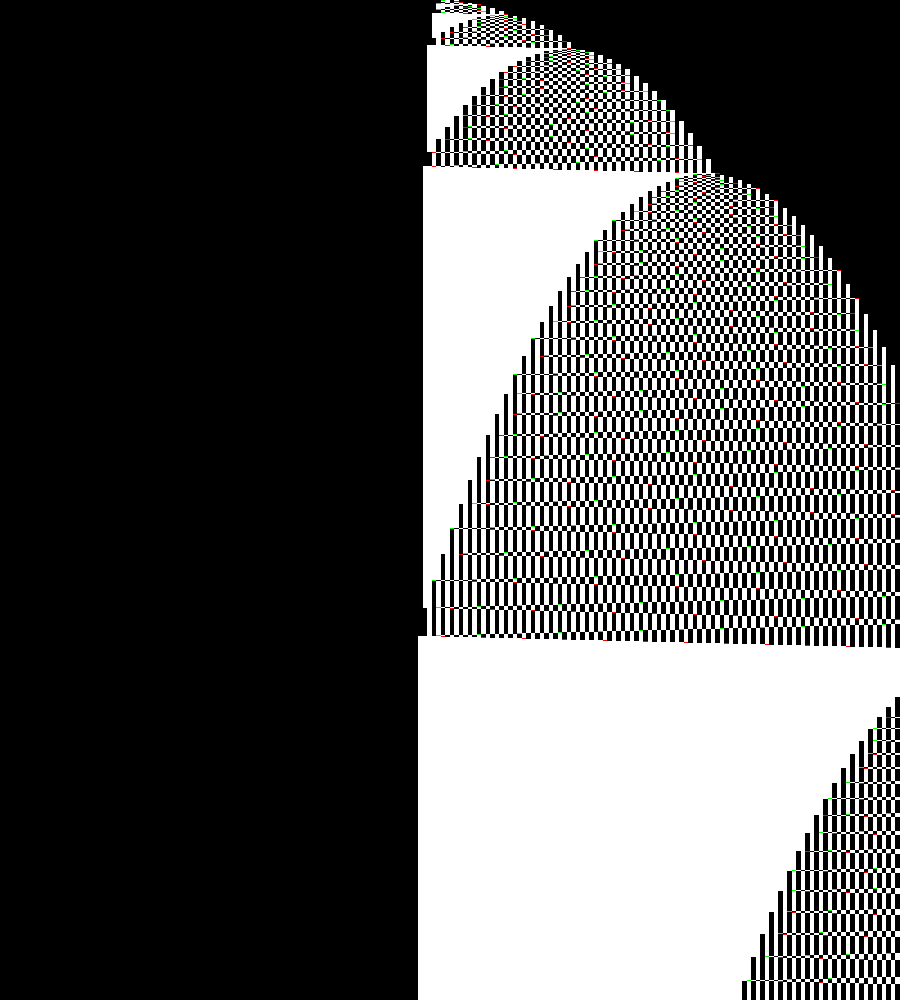

In [67]:
potential_halters_list = [73261028, 58360621, 8527536, 7911681, 28086713, 11059089, 2009846, 11670429, 7865218, 1973992]
# ^ they are all looking a lot like BB5 apart from 13754164 that looks like 20739 steps, 7658575 as well
n = random.choice(potential_halters_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=200, height=9000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Not classed yet

27879939


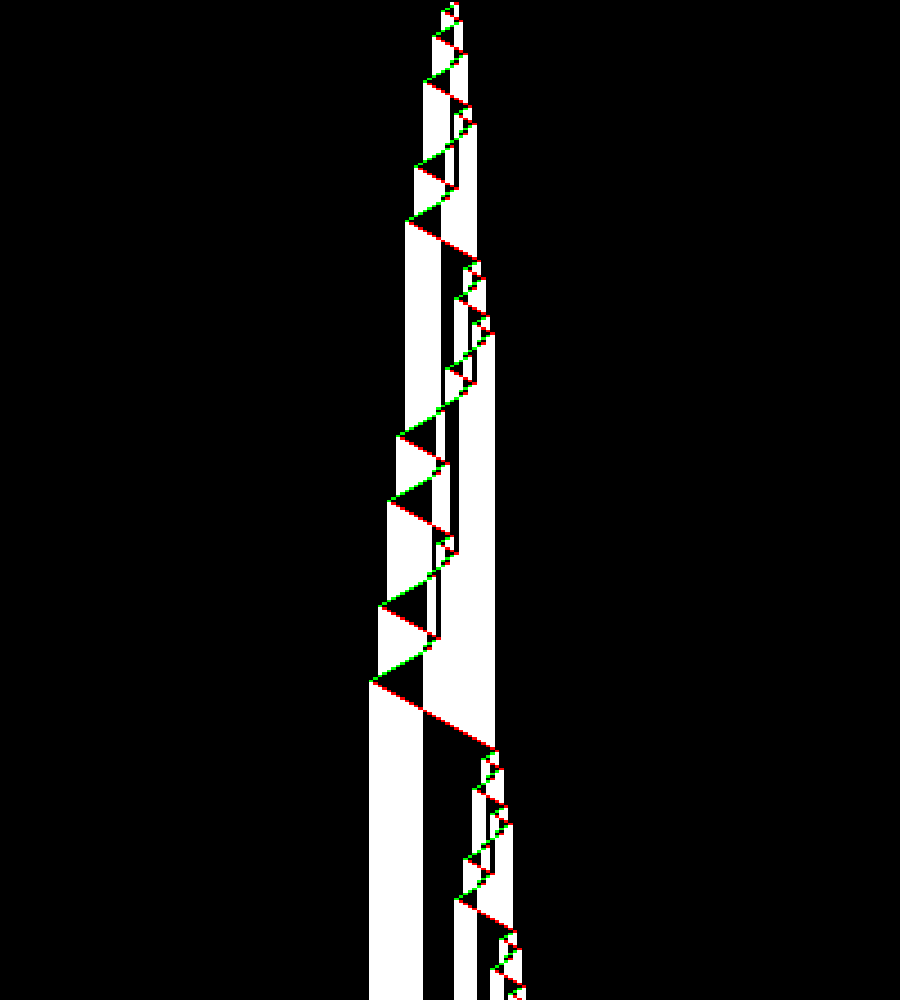

In [77]:
n_list = [2693691, 6490892, 8161712, 4920918, 73261028, 2364441, 5612126, 11274026, 
          2713328, 2394179, 27879939, 9390305, 43374927, 7038828, 42736705, 
          7530230, 7410754, 35201357]
n = random.choice(n_list)
print(n)
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=200, height=400, show_head_direction=True).resize((900,1000), Image.NEAREST)
img

## Funny/unrelevant

In [65]:
n_xmas = [6093803, 13099871]
bilateral_binary_counter = 3840180

## Backward Reasoning

Independtly of the behavior of a machine you can sometimes tell that it doesnt halt by simulating it backwards from undefined transitions and realising that it always lead to a contradiction. 

See https://discuss.bbchallenge.org/t/decider-backward-reasoning/35/2

Example:

1973992
s    0    1
---  ---  ---
A    1RB  ???
B    1RC  0LE
C    1LD  0RB
D    1LB  1LD
E    1RB  0LD


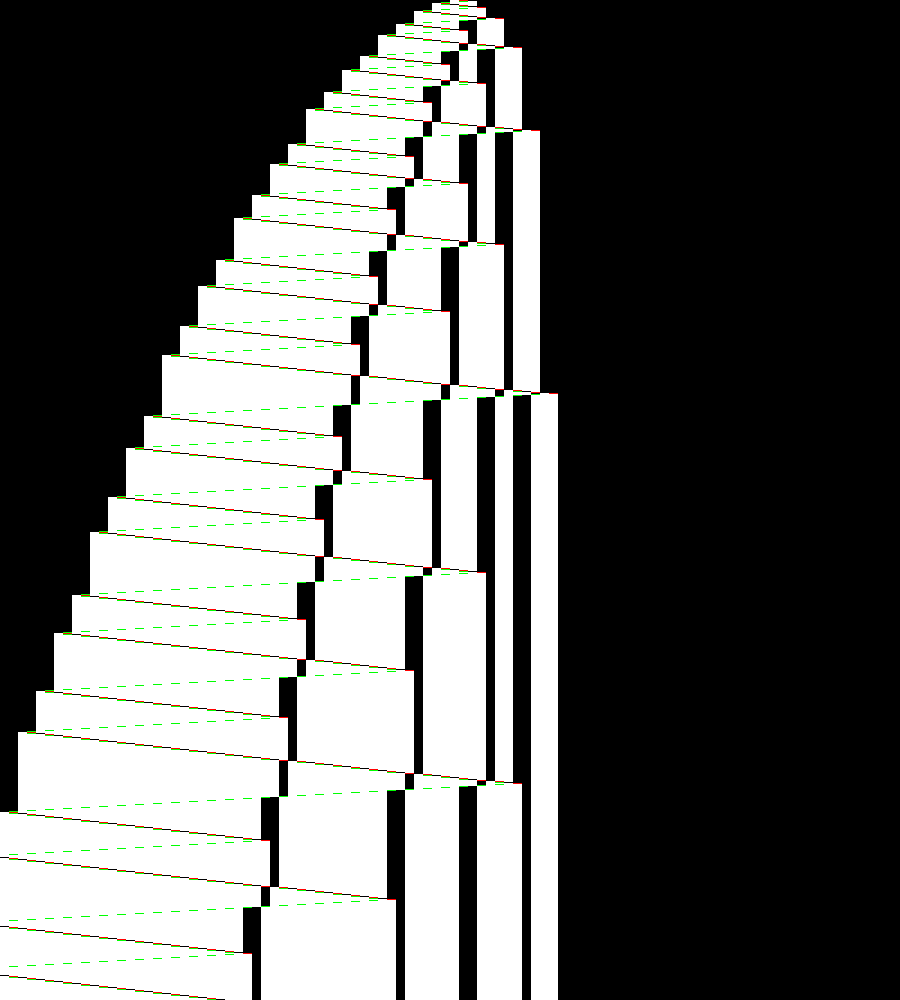

In [66]:
n_backward_reasoning_list = [4843748, 58360621, 2009846, 1973992, 11176971, 4147941, 12071224]
n = random.choice(n_backward_reasoning_list)
print(n)
pptm(get_machine_i(DB_PATH,n))
img = tm_trace_to_image(get_machine_i(DB_PATH,n), origin=0.5, width=100, height=2000, show_head_direction=True).resize((900,1000), Image.NEAREST)
img